In [ ]:
from google.colab import drive
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import numpy as np
import os 
from os import listdir
from random import sample
import pandas as pd
import random
np.random.seed(2)
np.random.RandomState(2)
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model
import sklearn
from collections import Counter
tf.random.set_seed(2)

# A Note on File Paths

The below code was written in Google Colab due to the time required to model the data. This notebook was mounted on the Google Drive, on the code file paths reflect as such. 

Similarly named files, i.e. the original images saved down in a file called 'raw_dataset' should result in the code running without issues.

If any guidance is required, users are encouraged to reach out via Github.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read in the image datasets.

In [ ]:
data_path = '/content/drive/MyDrive/clothing_class/raw_dataset'
imseg_data_path_kmeans = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_kmeans'
imseg_data_path_kmeans3 = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_kmeans3'
imseg_data_path_contour = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_contour'
imseg_data_path_thresh = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_thresholding'

Setting up a list of the file names inside the image folder.

In [ ]:
data_files = os.listdir(data_path)

## Read in CSV Files

Full and resampled (downsampled solids) dataset read in below.

In [ ]:
clothes_df = pd.read_csv('/content/drive/MyDrive/clothing_class/dataset.csv')
resampled_df = pd.read_csv('/content/drive/MyDrive/clothing_class/data_resampled.csv')

## Image Data Generator

A series of image augmentations were added to enhance performance. The training images are rescaled, flipped vertically/horizontally, rotated up to 40 degrees, shifted in width, height, slant, and zoom. This aims to provide the model with additional versions of the image, and more data, on which to train.

The test set is rescaled.

The dataset is split 80% to training, 20% to validation.

In [ ]:
aug_train_gen = ImageDataGenerator(
    rescale = 1/255,
    vertical_flip = True,
    horizontal_flip = True,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    rescale = 1/255,
    validation_split=0.2,
)

Creating a training generator that only flips horizontally and rotates the images.

In [ ]:
la_train_gen = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip = True,
    rotation_range = 40,
    validation_split=0.2,
)

## Generate Image Tensor Data

The function below generates the tensor data that will be used for modeling.

The function can be used for both training and testing sets, both garment and pattern modeling via the y-col argument, and reads in a specified dataset so that any of the segmented datasets can be selected.

In [ ]:
def tensor_data(image_gen,data_frame,image_data_path,y_column,subset):
  tensor_data = image_gen.flow_from_dataframe(
  dataframe=data_frame,
  directory=image_data_path,
  x_col="file_name",
  y_col=y_column,
  batch_size=32,
  shuffle=False,
  color_mode='rgb',
  class_mode="categorical",
  subset=subset,
  random_state=2,
  seed=2,
  target_size=(224,224),
  validate_filenames=False)

  return tensor_data

## Early Stop

Initializing an early stop regularization that will monitor increases in val loss metric.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           verbose=0,
                          )

## Checkpoint

This checkpoint feature will save down the best performing epoch, based on validation accuracy, that will provide a model on which predictions and evaluations can be performed.

In [ ]:
def checkpoint(cp_name):
  return ModelCheckpoint(
                             monitor='val_accuracy', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto',
                             filepath ='/content/drive/MyDrive/clothing_class/models/'+str(cp_name)
                             )

## Model Functions

I elected to proceed with showcasing the transfer learning modeling using VGG16 alone for this stage.

The below function allows for the Dense layer units to be specified, as well as for an Adam learning rate to be specified. Generally a learning rate of .01 was used when modeling with VGG16 transfer learning during this stage of analysis.

In addition to the layers inherent to the VGG architecture, additional Dense, Batch normalization, and dropout layers were addded. This particular architecture seemed to generate the best scores accross the various image sets.

In [ ]:
def model_function(classes,alr):
  
    base_model = VGG16(include_top=False,
                     input_shape=(224, 224, 3),
                     weights='imagenet'
                     )
    for layer in base_model.layers:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        
        base_model,
        
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(64,activation='relu'),

        tf.keras.layers.Dense(units=classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=alr),
        metrics=['accuracy']
    )
    
    return model

To observe the impact of transfer learning, an additional function was set up with a similar structure to the above VGG model, without the transfer learning.

In [ ]:
def seq_model_function(classes,alr):

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu',
                 padding='same',input_shape=(224,224,3)))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))

  model.add(Dense(units=classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy',metrics="accuracy",optimizer=Adam(learning_rate=alr))

  return model

## Plot Functions

A function was built to plot the accuracy and validation accuracy at each epoch. The plot is displayed and saved down to a seperate folder.

In [ ]:
def plot_accuracy(history,title,ext):
  plt.figure(figsize=(20,10))
  plt.plot(history.history['accuracy'], label='Train')
  plt.plot(history.history['val_accuracy'], label='Test')
  plt.ylabel('Accuracy',fontsize=20)
  plt.xlabel('Epochs',fontsize=20)
  plt.legend(prop={'size': 20})
  plt.title(title,fontsize=20)
  plt.savefig('/content/drive/MyDrive/clothing_class/jpeg_folder/'+str(ext)+'_acc.jpeg',format='jpeg',bbox_inches='tight');

A function was built to plot the confusion matrix for each model, using the model predictions and the ground truths for the test set. The matrix is displayed and saved down to a seperate folder.

In [ ]:
def plot_confusion_matrix(checkpoint,test_data,title,ext):
  preds = load_model('/content/drive/MyDrive/clothing_class/models/'+checkpoint).predict(test_data)
  top_pred = np.argmax(preds,axis=1)

  labels = (test_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in top_pred]

  label_true = [labels[k] for k in test_data.classes]

  fig,ax = plt.subplots(figsize=(20,10))
  ConfusionMatrixDisplay.from_predictions(label_true,
                                        predictions,cmap='Blues',
                                        ax=ax,
                                        )
  ax.set_xlabel('Predicted Label',fontsize=15)
  ax.set_ylabel('True Label',fontsize=15)
  plt.title(title,fontsize=20)
  plt.show()
  fig.savefig('/content/drive/MyDrive/clothing_class/jpeg_folder/'+str(ext)+'_cm.jpeg',format='jpeg',bbox_inches='tight');

## Function for Calculating Balanced Accuracy

A function was created to calculate the balanced accuracy for a given model and dataset.

In [ ]:
def calculate_balanced_acc(model,dataframe,image_file,y_col):
  
  test_data = tensor_data(test_gen,dataframe,image_file,
                   y_col,'validation')
  
  preds = load_model('/content/drive/MyDrive/clothing_class/models/'+model).predict(test_data)
  top_pred = np.argmax(preds,axis=1)

  labels = (test_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in top_pred]

  label_true = [labels[k] for k in test_data.classes]

  return sklearn.metrics.balanced_accuracy_score(label_true,predictions)

## Baselines

Reviewing the baseline values for these datasets to determine the accuracy level that must be surpassed to determine that a model performs better than merely choosing the majority class every time.

In [ ]:
clothes_df['garment_label'].value_counts(normalize=True)

dress      0.139226
sweater    0.136002
coat       0.134484
pants      0.129932
tshirt     0.116654
top        0.107360
jacket     0.087253
shorts     0.086495
skirt      0.062595
Name: garment_label, dtype: float64

The garment baseline for the dataset is ~14%.

In [ ]:
clothes_df['pattern_label'].value_counts(normalize=True)

solid        0.567527
horiz        0.161798
polka        0.091426
vertical     0.040971
chevron      0.039264
checkered    0.039264
animal       0.036039
paisley      0.023710
Name: pattern_label, dtype: float64

The pattern baseline for the whole dataset is 56.7%.

In [ ]:
resampled_df['pattern_label'].value_counts(normalize=True)

horiz        0.296386
solid        0.207783
polka        0.167477
vertical     0.075052
chevron      0.071925
checkered    0.071925
animal       0.066018
paisley      0.043433
Name: pattern_label, dtype: float64

The pattern baseline for the resampled dataset (which downsamples solid patterns) is ~30%. The resampled dataset will only be used for pattern modeling.

# Modeling 

The below modeling aims to identify the augmentation/segmentation that generates the best accuracy when attempting to classify type of garment/garment pattern within an image.

It should be noted that the test sets are segmented as well (but not augmented). If a certain kind of segmentation especially lends itself to classifying type of garment or pattern, we would consider segmenting future 'new' images as they are received and prepared to be classified.

## Transfer Learning Pattern Model - KMeans (K=5)

58900480/58889256 [==============================] - 1s 0us/step
Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/mode

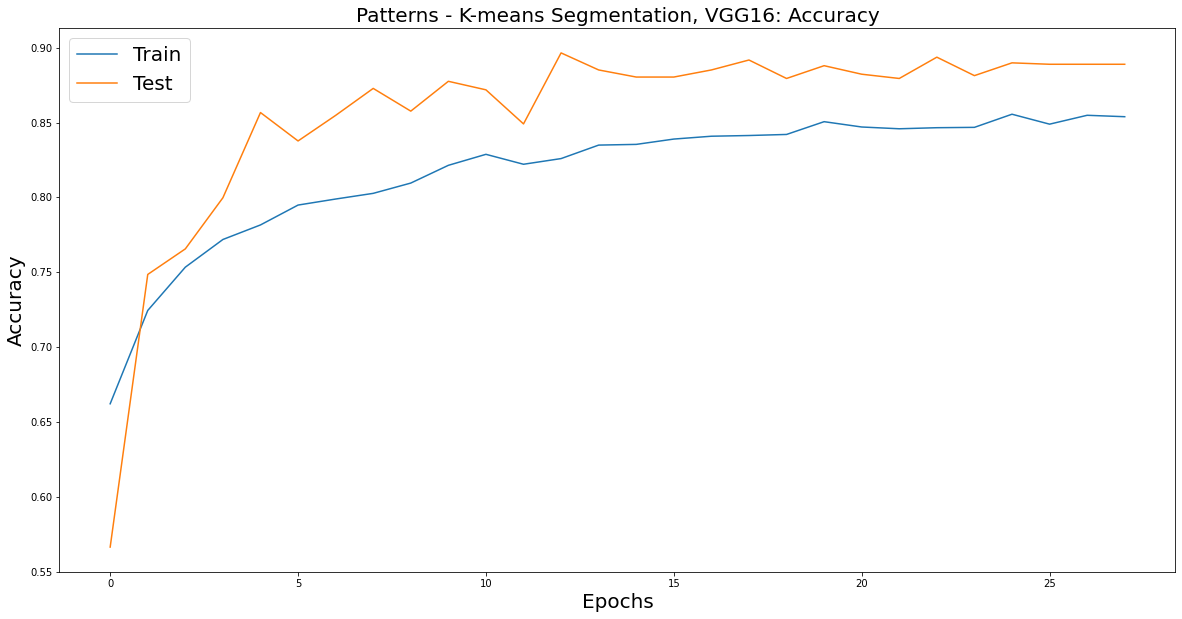

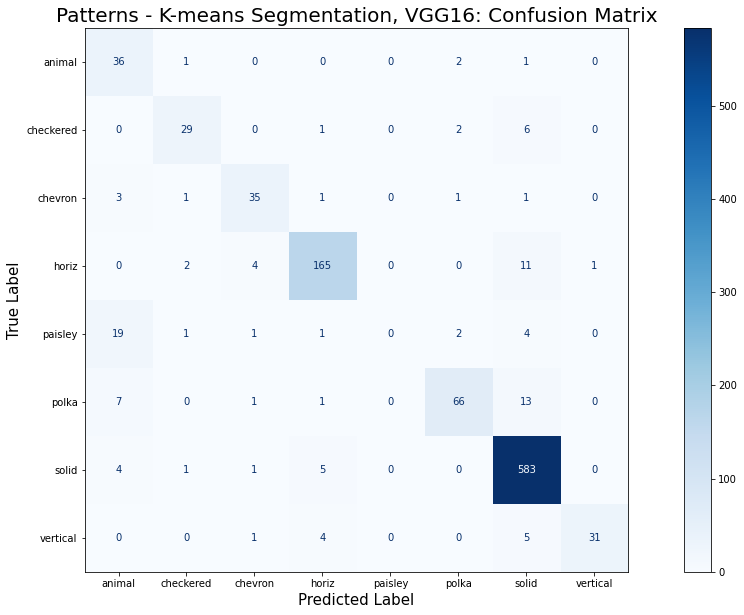

In [ ]:
model_vp_kmeans = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_kmeans,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_kmeans,
                  'pattern_label','validation')

checkpoint_model_vp_kmeans = checkpoint('model_vp_kmeans')

history_vp_kmeans = model_vp_kmeans.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_kmeans,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_kmeans,'Patterns - K-means Segmentation, VGG16: Accuracy',
              'kmeans_pattern_transfer')

plot_confusion_matrix('model_vp_kmeans',test_data,
                      'Patterns - K-means Segmentation, VGG16: Confusion Matrix',
                      'kmeans_pattern_transfer')

In [ ]:
max(history_vp_kmeans.history['val_accuracy'])

0.8965844511985779

The transfer learning model using K-Means segmented images scored fairly strongly on the pattern dataset, achieving a validation accuracy of 89.65%.

The areas of notable misclassification are horizontal, polkadot and paisley print being misclassified as solids.

In [ ]:
calculate_balanced_acc('model_vp_kmeans',clothes_df,imseg_data_path_kmeans,'pattern_label')

Found 1054 non-validated image filenames belonging to 8 classes.


0.7357137018486952

Due to the dataset's imbalance, the balanced accuracy on the testing set is 73.57%.

## Transfer Learning Model, K-Means (K=5) - Resampled Pattern Data

Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans_r/assets


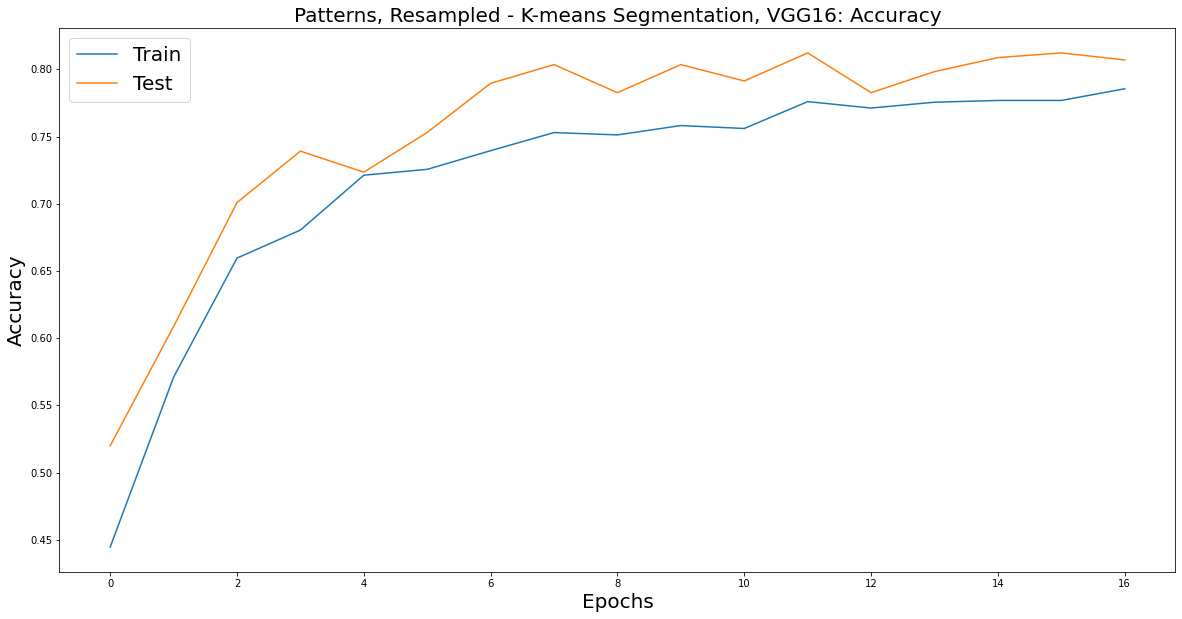

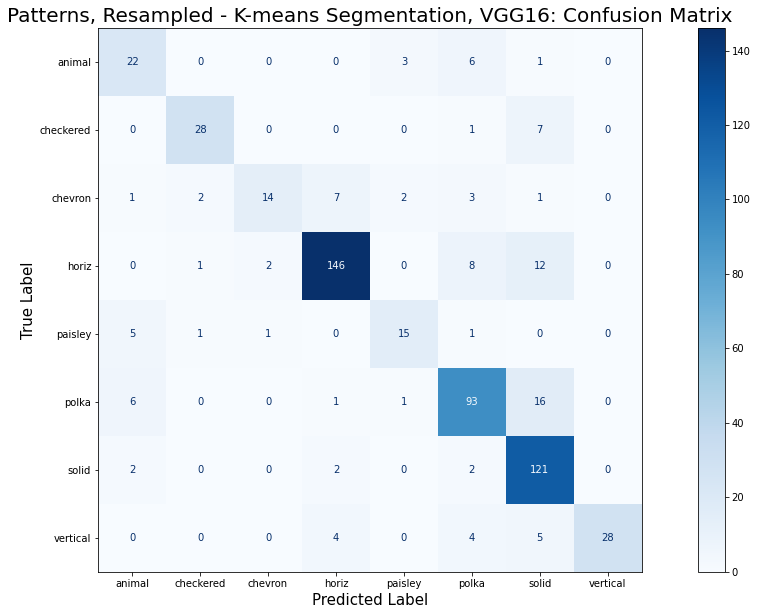

In [ ]:
model_vp_kmeans_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,resampled_df,imseg_data_path_kmeans,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,imseg_data_path_kmeans,
                  'pattern_label','validation')

checkpoint_model_vp_kmeans_r = checkpoint('model_vp_kmeans_r')

history_vp_kmeans_r = model_vp_kmeans_r.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_kmeans_r,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_kmeans_r,'Patterns, Resampled - K-means Segmentation, VGG16: Accuracy',
              'kmeans_pattern_transfer_r')

plot_confusion_matrix('model_vp_kmeans_r',test_data,
                      'Patterns, Resampled - K-means Segmentation, VGG16: Confusion Matrix',
                      'kmeans_pattern_transfer_r')

When reviewing the validation accuracy score of a model fed K-Means images on the dataset that drastically downsampled solids, accuracy fell relative to the less balanced dataset.

A misclassification pattern similar to the K-means misclassifications for the complete dataset developed on the more imbalanced data.

In [ ]:
max(history_vp_kmeans_r.history['val_accuracy'])

0.8121739029884338

In [ ]:
calculate_balanced_acc('model_vp_kmeans_r',resampled_df,imseg_data_path_kmeans,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.7348222765729511

Validation accuracy when using this data set is 81.21%, and balanced accuracy is 73.48%.

## Transfer Learning Garment Model - KMeans (K =5)

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans/assets


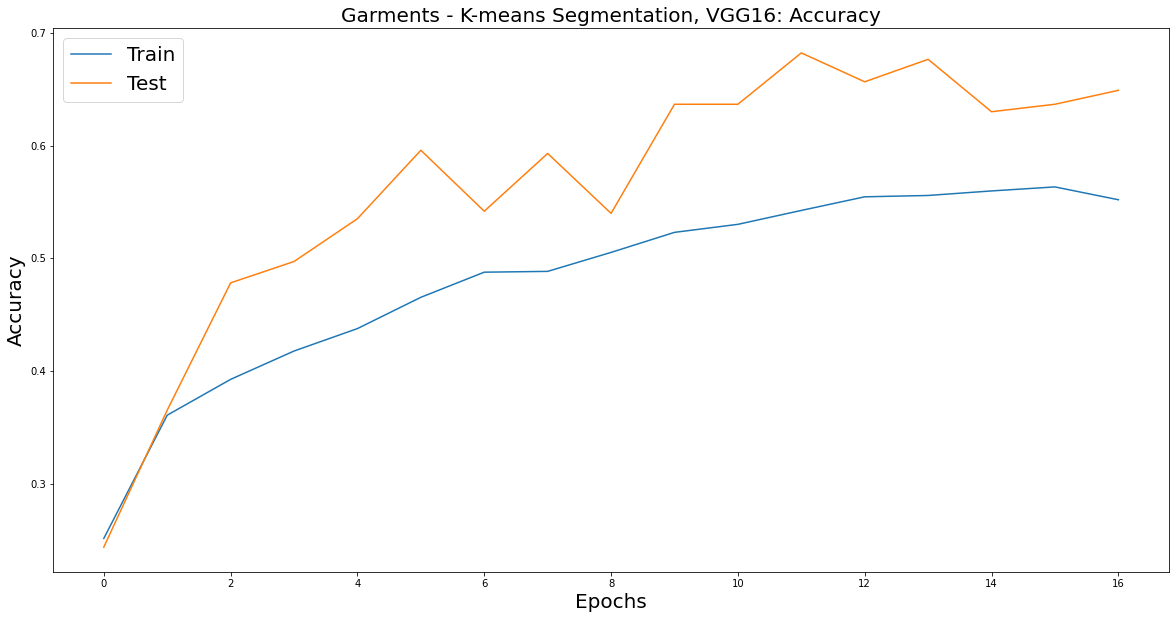

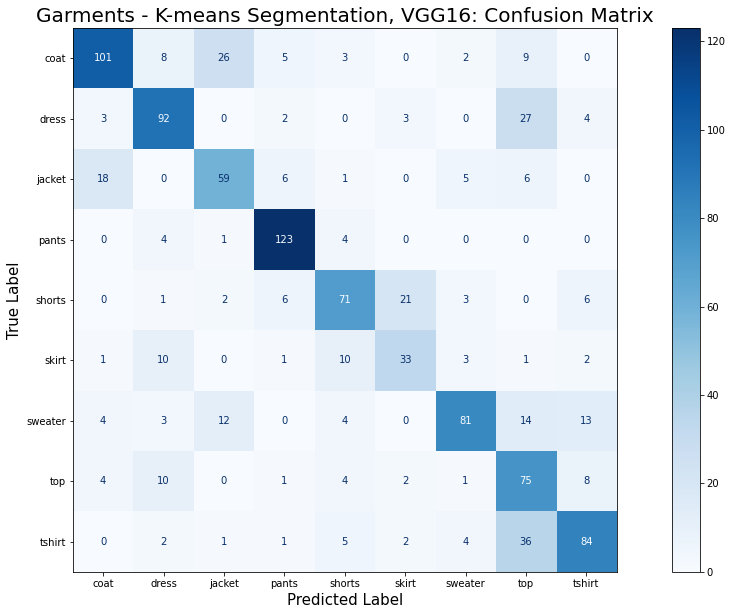

In [ ]:
model_vg_kmeans = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_kmeans,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_kmeans,
                  'garment_label','validation')

checkpoint_model_vg_kmeans = checkpoint('model_vg_kmeans')

history_vg_kmeans = model_vg_kmeans.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_kmeans,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_kmeans,'Garments - K-means Segmentation, VGG16: Accuracy',
              'kmeans_garment_transfer')

plot_confusion_matrix('model_vg_kmeans',test_data,
                      'Garments - K-means Segmentation, VGG16: Confusion Matrix',
                      'kmeans_garment_transfer')

In [ ]:
max(history_vg_kmeans.history['val_accuracy'])

0.6821631789207458

In [ ]:
calculate_balanced_acc('model_vg_kmeans',clothes_df,imseg_data_path_kmeans,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.6724746383093384

The type of garment is harder to identify in the images than pattern. 

The transfer learning model, when fed images segmented via 5 K-Means clusters, classified garments with a validation accuracy of 68.21%, and a balanced accuracy score of 67.24%.

Notable misclassifications are what might be expected, given the similarity in the nature of the items:
* Coats and jackets
* Tops/T-Shirts/Sweaters
* Dresses and Skirts

## Transfer Learning Model, K-Means (K=3) - Resampled Pattern Data

Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_kmeans3_r/assets
INFO:tensorflow:Assets 

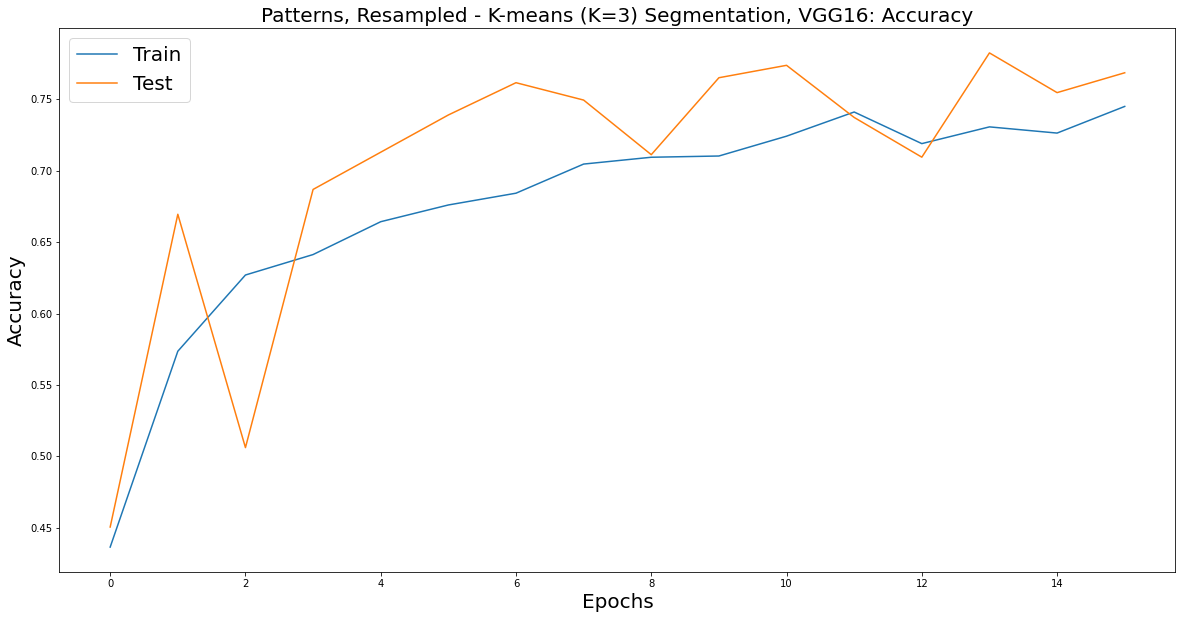

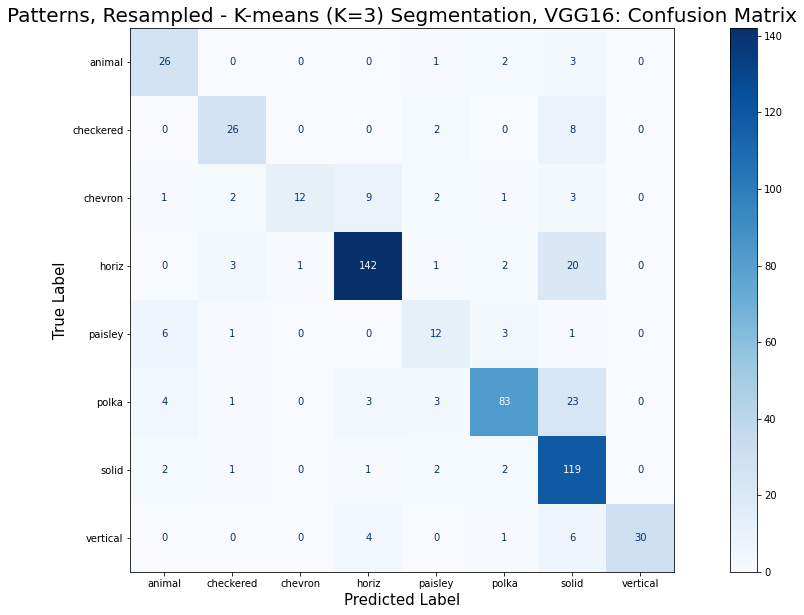

In [ ]:
model_vp_kmeans3_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,resampled_df,imseg_data_path_kmeans3,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,imseg_data_path_kmeans3,
                  'pattern_label','validation')

checkpoint_model_vp_kmeans3_r = checkpoint('model_vp_kmeans3_r')

history_vp_kmeans3_r = model_vp_kmeans3_r.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_kmeans3_r,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_kmeans3_r,'Patterns, Resampled - K-means (K=3) Segmentation, VGG16: Accuracy',
              'kmeans3_pattern_transfer_r')

plot_confusion_matrix('model_vp_kmeans3_r',test_data,
                      'Patterns, Resampled - K-means (K=3) Segmentation, VGG16: Confusion Matrix',
                      'kmeans3_pattern_transfer_r')

To see if reducing the number of clusters K-Means uses to segment the image might affect the accuracy, the similarly structured models were built using images segmented using only 3 clusters.

As might be expected when the image is segmented using fewer shading clusters, the model more often misclassifies striped (horizontal and chevron) and checkered patterns as solids because it is less proficient at distinguishing between the lines of stripe. 

In [ ]:
max(history_vp_kmeans3_r.history['val_accuracy'])

0.782608687877655

In [ ]:
calculate_balanced_acc('model_vp_kmeans3_r',resampled_df,imseg_data_path_kmeans3,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.7093518674422706

Ultimately, using fewer clusters in the K-Means segmentation negatively affected the balanced accuracy score, relative to the models fed images processed with 5 clusters. Validation accuracy was 78.26% and balanced accuracy was 70.94%.

## Transfer Learning - Garment Model, K-Means (K=3) Segmentation

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_kmeans3/assets


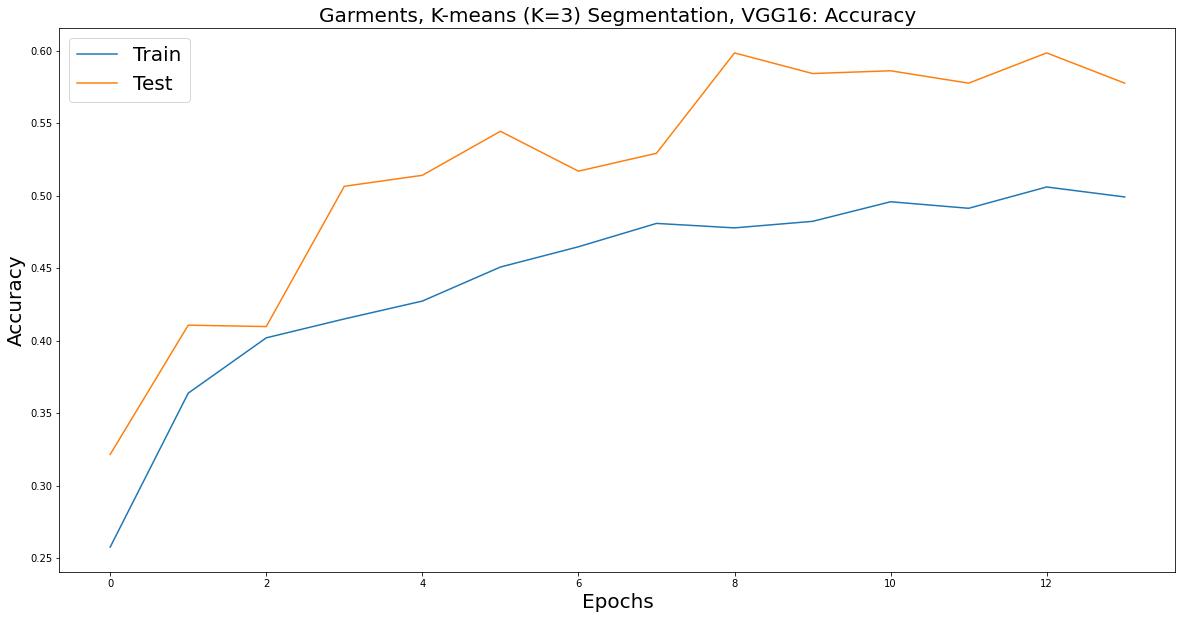

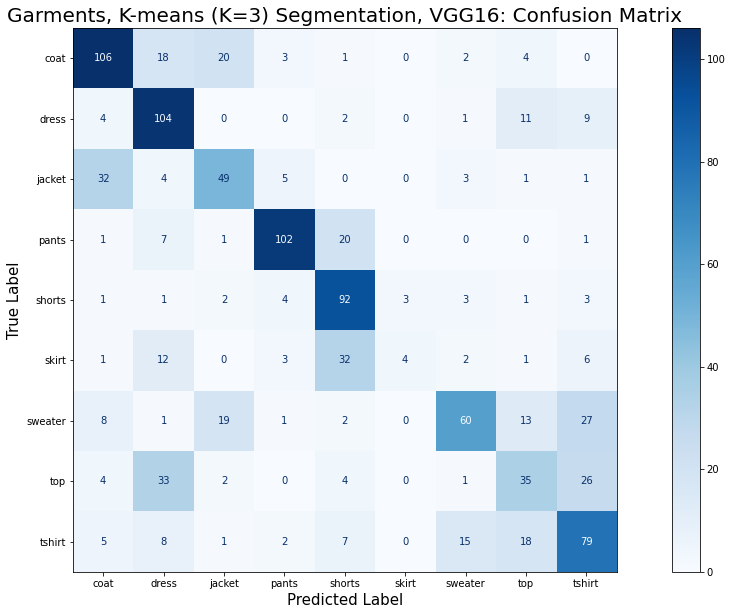

In [ ]:
model_vg_kmeans3 = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_kmeans3,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_kmeans3,
                  'garment_label','validation')

checkpoint_model_vg_kmeans3 = checkpoint('model_vg_kmeans3')

history_vg_kmeans3 = model_vg_kmeans3.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_kmeans3,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_kmeans3,'Garments, K-means (K=3) Segmentation, VGG16: Accuracy',
              'kmeans3_garment_transfer')

plot_confusion_matrix('model_vg_kmeans3',test_data,
                      'Garments, K-means (K=3) Segmentation, VGG16: Confusion Matrix',
                      'kmeans3_garment_transfer')

In [ ]:
max(history_vg_kmeans3.history['val_accuracy'])

0.5986717343330383

Similarly to pattern modeling, when using 3 clusters to segment the image via K-Means, the model classifying garments performed worse than the model fed data segmented with five clusters, with similar misclassifications.

## Sequential Pattern Model - Contour

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_contour/assets
INFO:tensorflow:Assets written to: /co

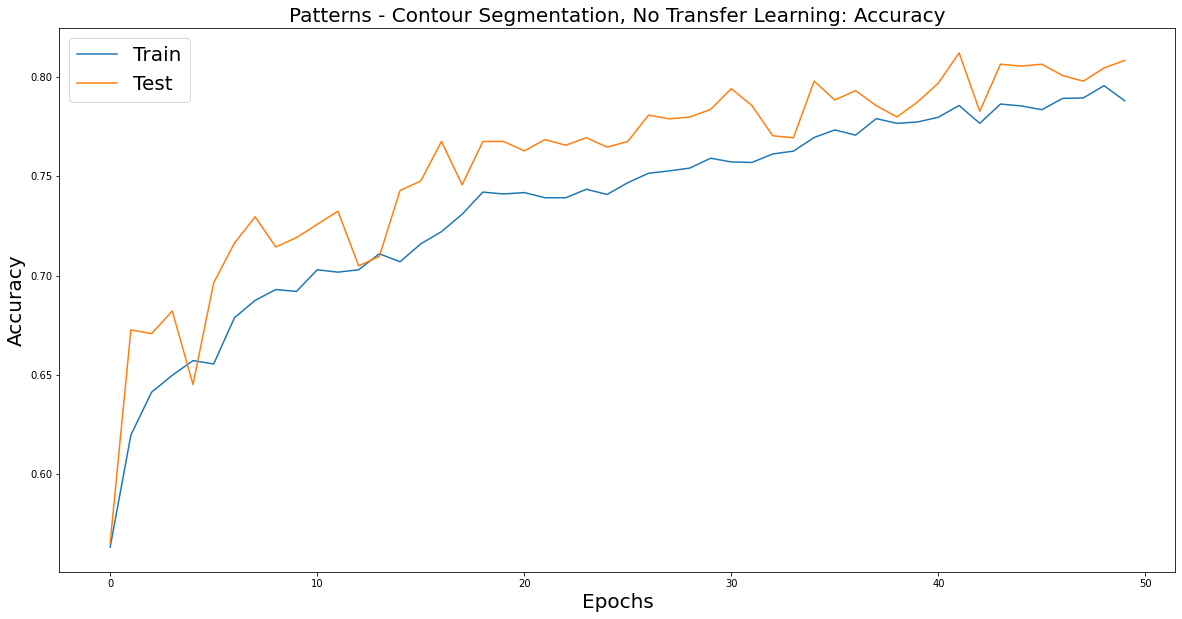

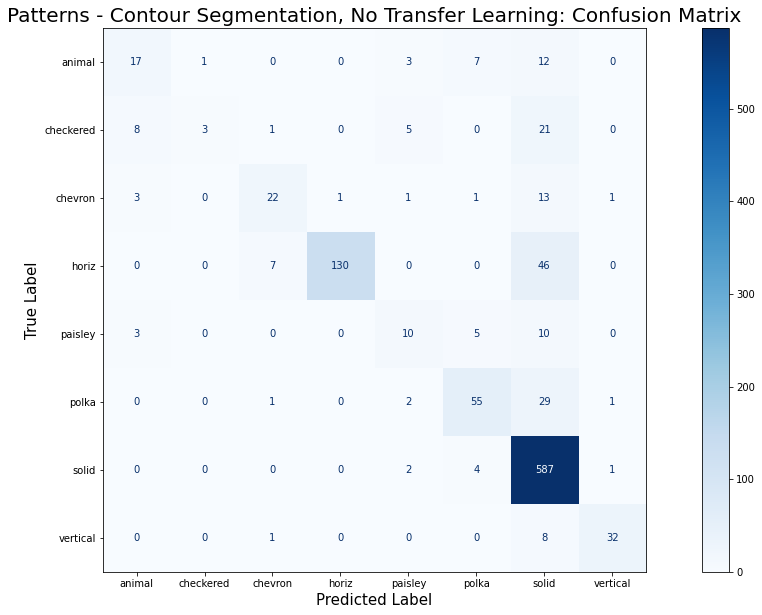

In [ ]:
model_sp_contour = seq_model_function(classes = 8,alr=.001)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_contour,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_contour,
                  'pattern_label','validation')

checkpoint_model_sp_contour = checkpoint('model_sp_contour')

history_sp_contour = model_sp_contour.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_sp_contour,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_sp_contour,'Patterns - Contour Segmentation, No Transfer Learning: Accuracy',
              'contour_pattern_cnn')

plot_confusion_matrix('model_sp_contour',test_data,
                      'Patterns - Contour Segmentation, No Transfer Learning: Confusion Matrix',
                      'contour_pattern_cnn')

In [ ]:
max(history_sp_contour.history['val_accuracy'])

0.8121442198753357

The models that did not utilize transfer learning performed better for the contour segmented images than the models that used transfer learning. With its highest validation accuracy level at ~81.21%, the model using contoured images does not perform as well as the model using K-Means images with 5 clusters.

Notable misclassifications again include paisley, polka and horizontal stripes but animal print, checkered and chevron striped misclassifications also become more common than in the K-Means model.

## Transfer Learning Garment Model - Contour

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_contour/assets
INFO:tensorflow:Assets written to: /co

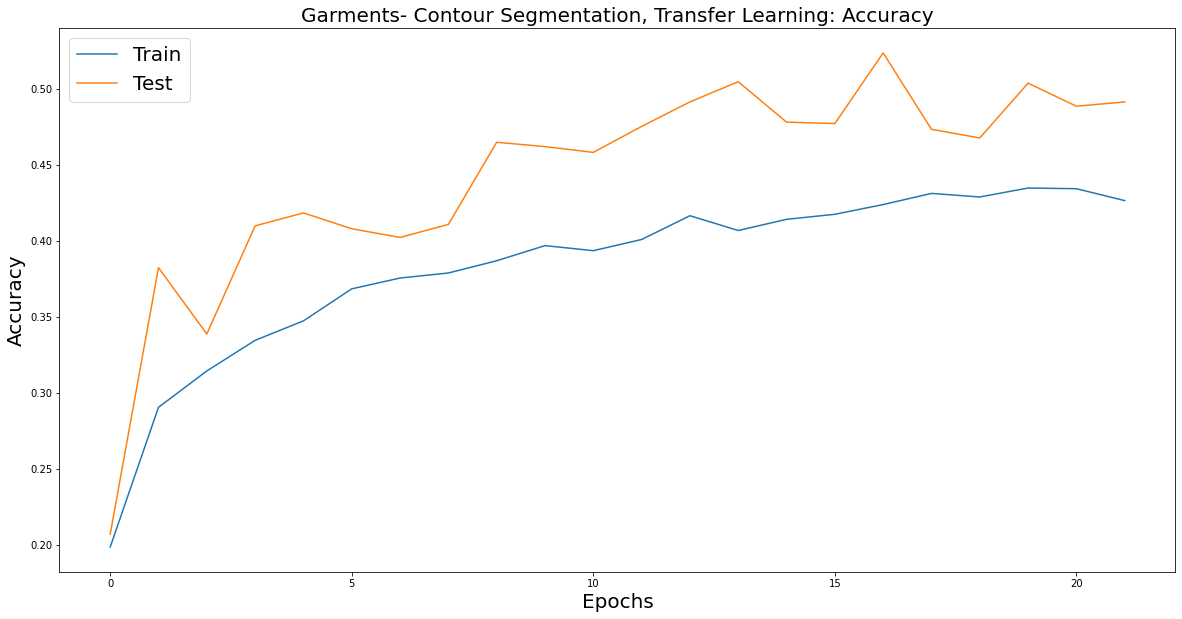

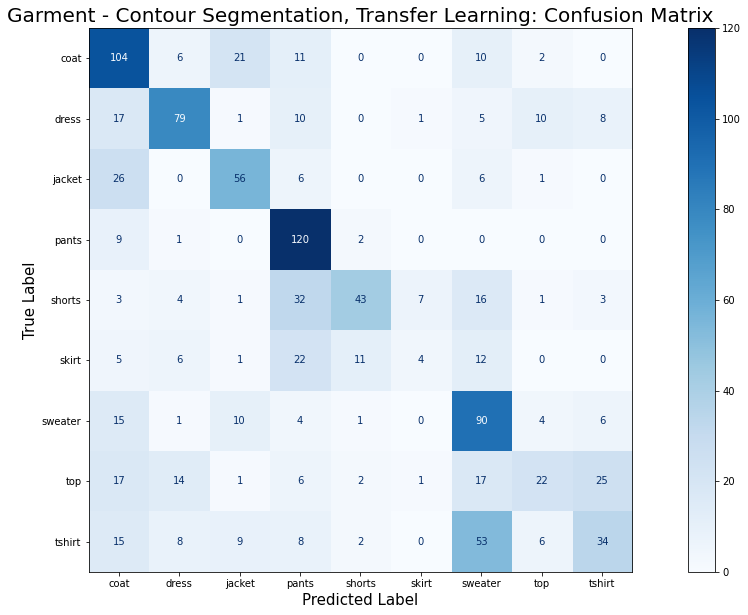

In [ ]:
model_vg_contour = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_contour,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_contour,
                  'garment_label','validation')

checkpoint_model_vg_contour = checkpoint('model_vg_contour')

history_vg_contour = model_vg_contour.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_contour,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_contour,'Garments- Contour Segmentation, Transfer Learning: Accuracy',
              'contour_garment_transfer')

plot_confusion_matrix('model_vg_contour',test_data,
                      'Garment - Contour Segmentation, Transfer Learning: Confusion Matrix',
                      'contour_garment_transfer')

In [ ]:
max(history_vg_contour.history['val_accuracy'])

0.5237191915512085

The model fed the contour segmented images, when using transfer learning, performs considerably worse than the K-Means trained model, with its best validation accuracy of 52.37%. Areas of frequent misclassification, in addition to those that are frequent in the K-Means model are:

* Shorts/pants
* Sweater/jacket


## Sequential Pattern Model - Thresholding

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sp_thresh/assets
INFO:tensorflow:Assets written to: /content/dr

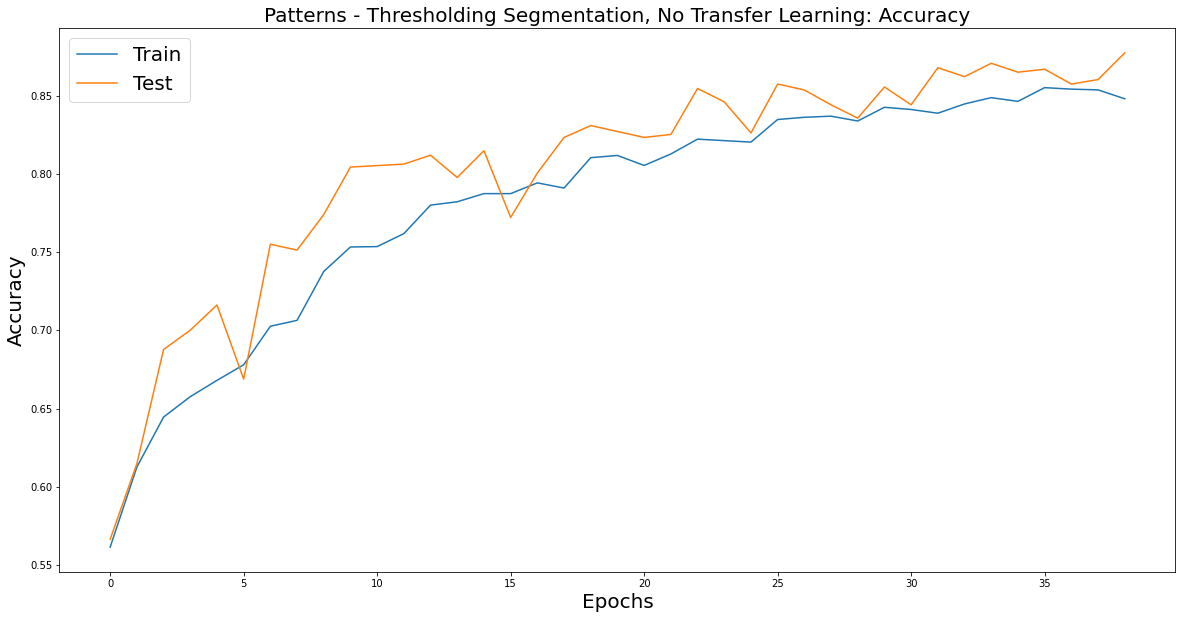

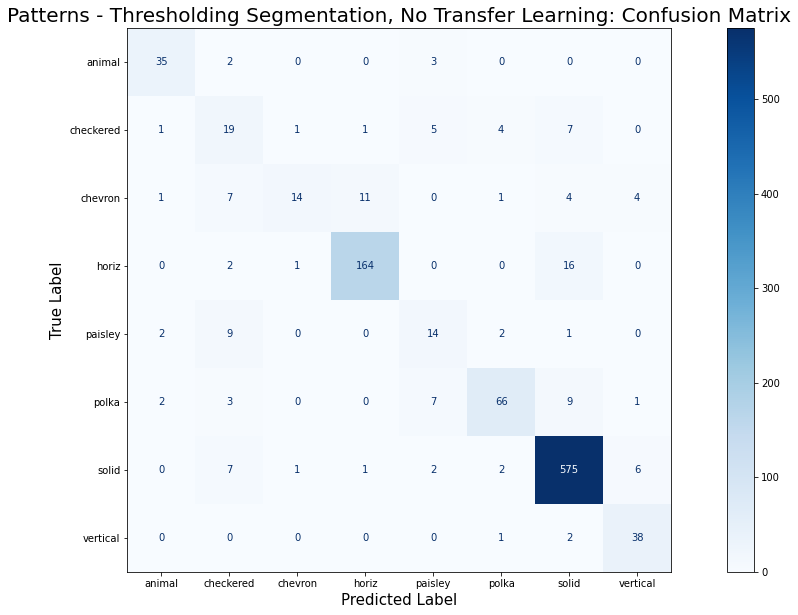

In [ ]:
model_sp_thresh = seq_model_function(classes = 8,alr=.001)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_thresh,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_thresh,
                  'pattern_label','validation')

checkpoint_model_sp_thresh = checkpoint('model_sp_thresh')

history_sp_thresh = model_sp_thresh.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    validation_data = test_data,
    verbose=0,
    callbacks = [checkpoint_model_sp_thresh,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_sp_thresh,'Patterns - Thresholding Segmentation, No Transfer Learning: Accuracy',
              'thresh_pattern_cnn')

plot_confusion_matrix('model_sp_thresh',test_data,
                      'Patterns - Thresholding Segmentation, No Transfer Learning: Confusion Matrix',
                      'thresh_pattern_cnn')

In [ ]:
max(history_sp_thresh.history['val_accuracy'])

0.877609133720398

For thresholding segmented images, the models that did not use transfer learning again performed better. At ~87.76%, the validation accuracy for the thresholding model is higher than contouring, but lower than K-Means.

Unlike the model that was fed contoured images, vertical stripes and animal prints were not notable areas of mislcassifications. The thresholding image model does misclassify paisley as checkered and polka, and misclassifies chevron and checkered at a similar rate to the contour model.

## Sequential Garment Model - Thresholding

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_sg_thresh/assets
INFO:tensorflow:Assets written to: /content/dr

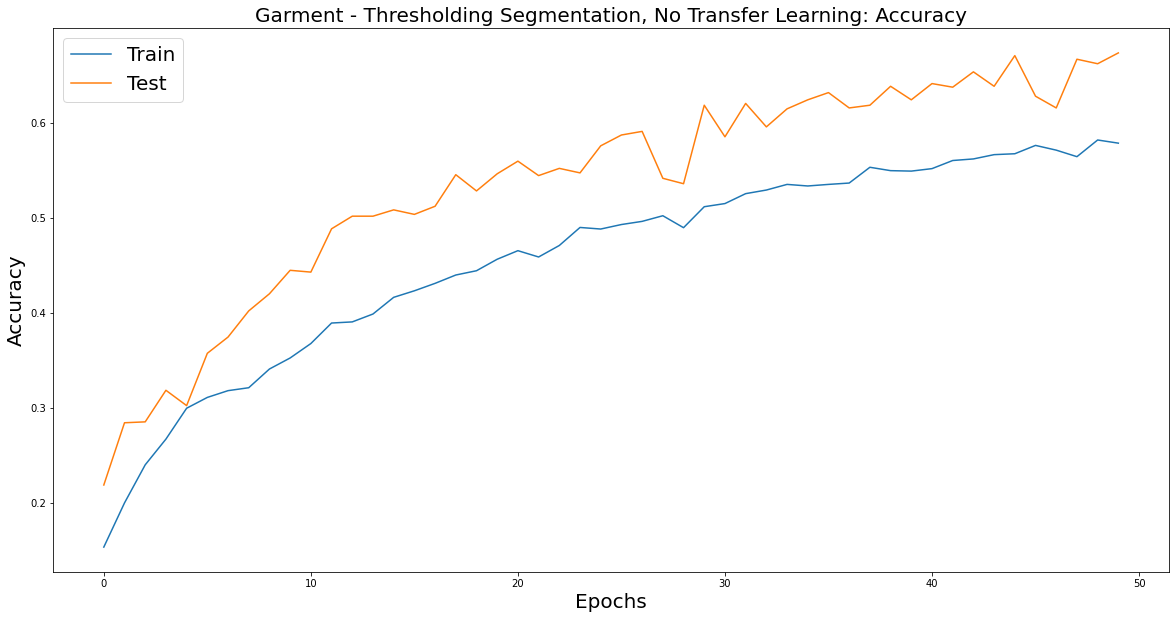

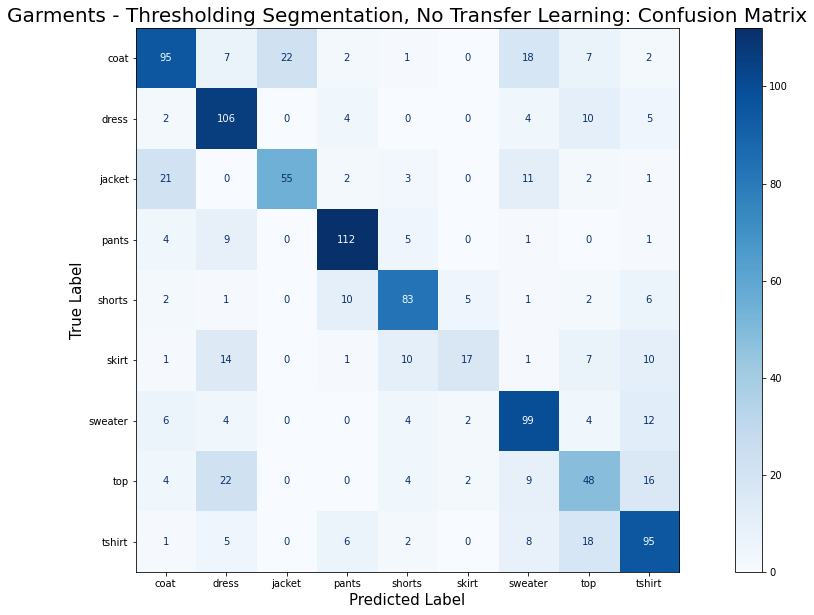

In [ ]:
model_sg_thresh = seq_model_function(classes = 9,alr=.001)

train_data = tensor_data(aug_train_gen,clothes_df,imseg_data_path_thresh,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,imseg_data_path_thresh,
                  'garment_label','validation')

checkpoint_model_sg_thresh = checkpoint('model_sg_thresh')

history_sg_thresh = model_sg_thresh.fit(
    train_data,
    batch_size = 32,
    verbose=0,
    epochs=50,
    validation_data = test_data,
    callbacks = [checkpoint_model_sg_thresh,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_sg_thresh,'Garment - Thresholding Segmentation, No Transfer Learning: Accuracy',
              'thresh_garment_cnn')

plot_confusion_matrix('model_sg_thresh',test_data,
                      'Garments - Thresholding Segmentation, No Transfer Learning: Confusion Matrix',
                      'thresh_garment_cnn')

In [ ]:
max(history_sg_thresh.history['val_accuracy'])

0.6736242771148682

In [ ]:
calculate_balanced_acc('model_sg_thresh',clothes_df,imseg_data_path_thresh,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.6448090411060448

The thresholding model, which did not use transfer learning, performed with a validation accuracy slightly lower than that of the K-Means segmentation.

Notable areas of misclassificationa are:
* Jacket/Coat
* Top/Sweater/Dress

## Transfer Learning Pattern Model - No Segmentation

Found 4218 non-validated image filenames belonging to 8 classes.
Found 1054 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_noseg/assets
INFO:tensorflow:Assets written to: /content/drive/MyDr

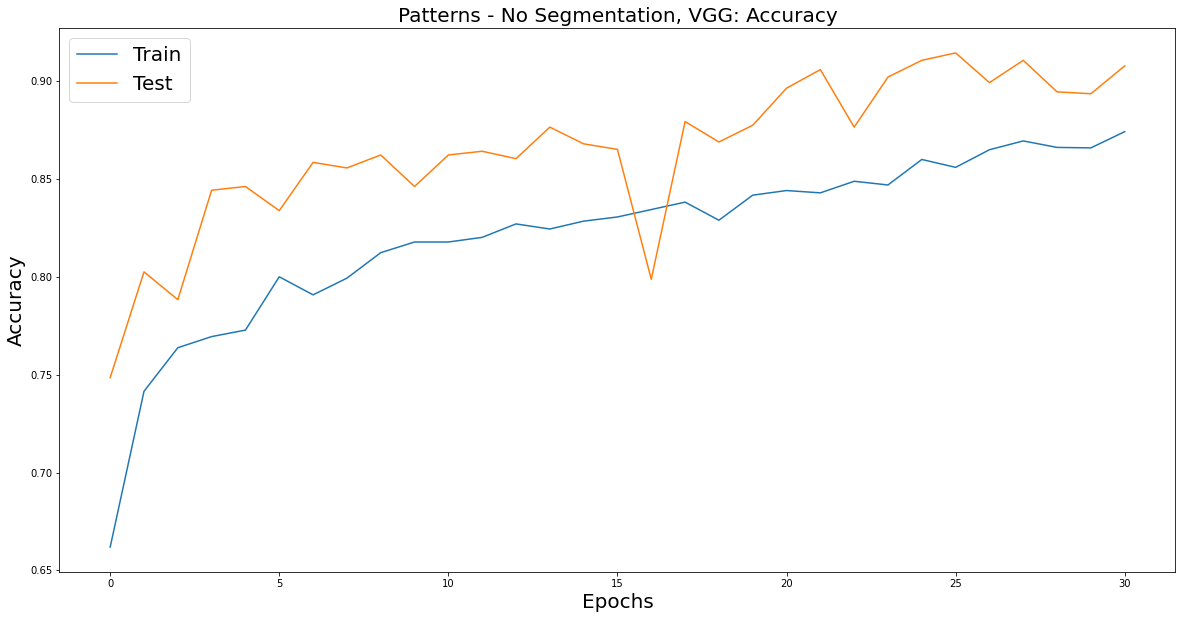

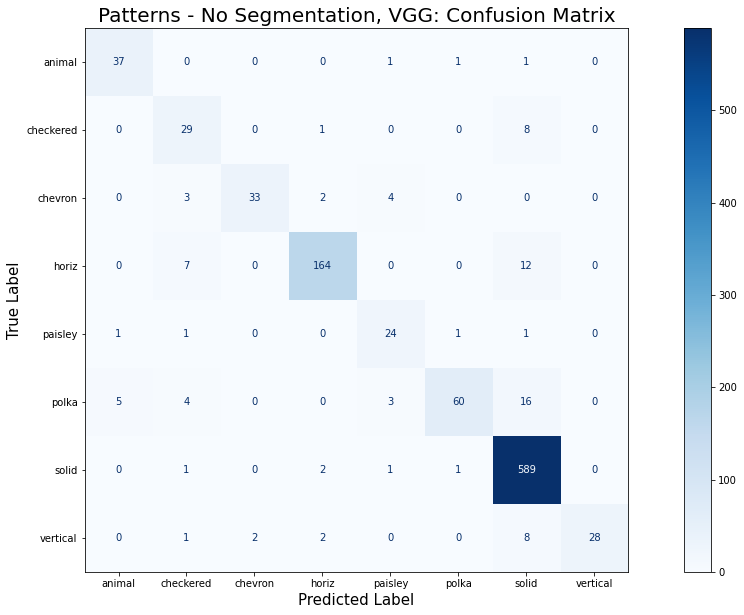

In [ ]:
model_vp_noseg = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,data_path,
                  'pattern_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'pattern_label','validation')

checkpoint_model_vp_noseg = checkpoint('model_vp_noseg')

history_vp_noseg = model_vp_noseg.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_noseg,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_noseg,'Patterns - No Segmentation, VGG: Accuracy',
              'noseg_pattern_transfer')

plot_confusion_matrix('model_vp_noseg',test_data,
                      'Patterns - No Segmentation, VGG: Confusion Matrix',
                      'noseg_pattern_transfer')

In [ ]:
max(history_vp_noseg.history['val_accuracy'])

0.9146109819412231

In [ ]:
calculate_balanced_acc('model_vp_noseg',clothes_df,data_path,'pattern_label')

Found 1054 non-validated image filenames belonging to 8 classes.


0.8229396754563661

At ~91.5% validation accuracy, the model that used transfer learning and no image segmentation performed similarly strong to the K-Means segmented model, which achieved ~89.65% validation accuracy.

Notable misclassification areas include polka, checkered and paisley.

The model that did not use segementation also surpasses the K-Means fed model in balanced accuracy.

## Transfer Learning Model, No Segmentation - Resampled Pattern Data

In [ ]:
model_vp_noseg_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(aug_train_gen,resampled_df,data_path,
                   'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,data_path,
                   'pattern_label','validation')

checkpoint_model_vp_noseg_r = checkpoint('model_vp_noseg_r')

history_vp_noseg_r = model_vp_noseg_r.fit(
     train_data,
     batch_size = 32,
     epochs=50,
     verbose=0,
     validation_data = test_data,
     callbacks = [checkpoint_model_vp_noseg_r,early_stop],
     validation_batch_size=32
 )

plot_accuracy(history_vp_noseg_r,'Patterns, Resampled - No Segmentation, VGG16: Accuracy',
              'noseg_pattern_transfer_r')

plot_confusion_matrix('model_vp_noseg_r',test_data,
                       'Patterns, Resampled - No Segmentation, VGG16: Confusion Matrix',
                       'noseg_pattern_transfer_r')

In [ ]:
max(history_vp_noseg_r.history['val_accuracy'])

0.8365217447280884

In [ ]:
calculate_balanced_acc('model_vp_noseg_r',resampled_df,data_path,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.7725344306228321

The transfer learning model with no segmentation scored considerably better in balanced accuracy on the resampled dataset than the K-Means model, achieving a balanced accuracy score of 77.25% compared to the ~73.5% for the K-Means model with 5 clusters. 

## Transfer Learning Garment Model - No Segmentation

In [ ]:
model_vg_noseg = model_function(classes = 9,alr=.01)

train_data = tensor_data(aug_train_gen,clothes_df,data_path,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'garment_label','validation')

checkpoint_model_vg_noseg = checkpoint('model_vg_noseg')

history_vg_noseg = model_vg_noseg.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_noseg,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_noseg,'Garments - No Segmentation, VGG: Accuracy',
              'noseg_garment_transfer')

plot_confusion_matrix('model_vg_noseg',test_data,
                      'Garments - No Segmentation, VGG: Confusion Matrix',
                      'noseg_garment_transfer')

In [ ]:
max(history_vg_noseg.history['val_accuracy'])

0.7239089012145996

In [ ]:
calculate_balanced_acc('model_vg_noseg',clothes_df,data_path,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.70270942616026

The model that uses no image segmentation and transfer learning performs best out of the garment classifiers. The epoch with the best validation accuracy achieved an accuracy of 72.39%, and a balanced accuracy of 70.27%. Notable areas of misclassification are:

* Coat/Jacket
* Dress/Top

## Transfer Learning Model, No Segmentation, Less Augmentation - Resampled Pattern Data

In [ ]:
model_vp_nsa_r = model_function(classes = 8,alr=.01)

train_data = tensor_data(la_train_gen,resampled_df,data_path,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,data_path,
                  'pattern_label','validation')

checkpoint_model_vp_nsa_r = checkpoint('model_vp_nsa_r')

history_vp_nsa_r = model_vp_nsa_r.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_nsa_r,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vp_nsa_r,'Patterns, Resampled - No Segmentation, Low Augmentation VGG16: Accuracy',
              'nsa_pattern_transfer_r')

plot_confusion_matrix('model_vp_nsa_r',test_data,
                      'Patterns, Resampled - No Segmentation, Low Augmentation VGG16: Confusion Matrix',
                      'nsa_pattern_transfer_r')

In [ ]:
max(history_vp_nsa_r.history['val_accuracy'])

0.8399999737739563

In [ ]:
calculate_balanced_acc('model_vp_nsa_r',resampled_df,data_path,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.8024219778558483

When fewer augmentations were applied to the non-segmented image data, and fed into the transfer learning model, performance relative to the model that was fed more augmented image data was quite similar. 

The confusion matrices are very similar. 

## Transfer Learning - Garment Model, No Segmentation, Less Augmentation 

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa/assets


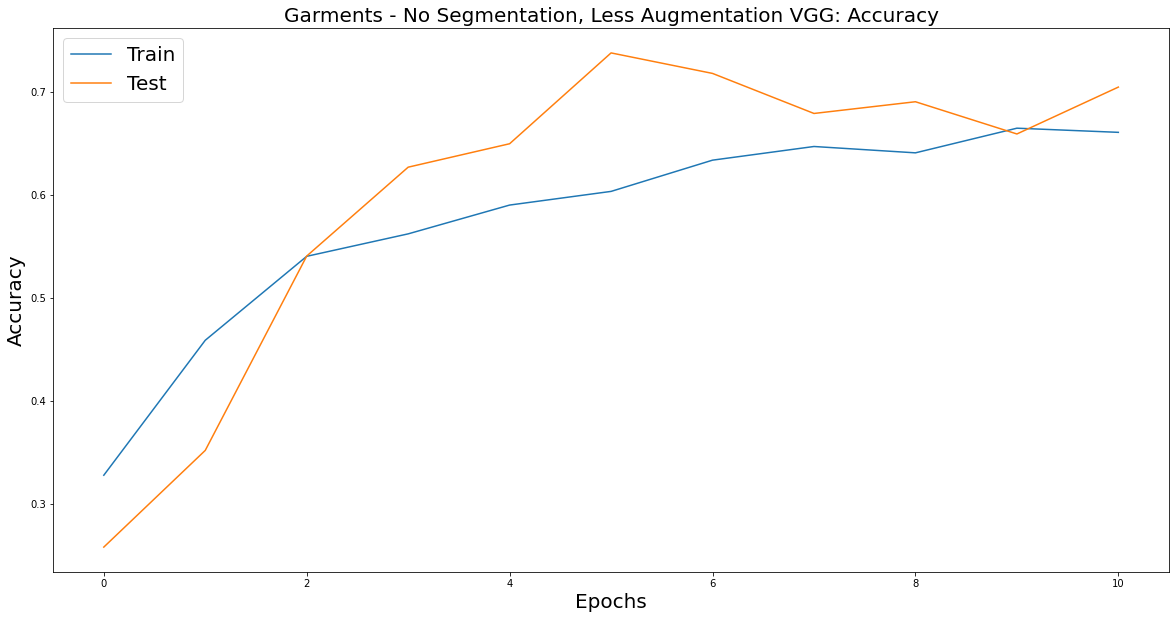

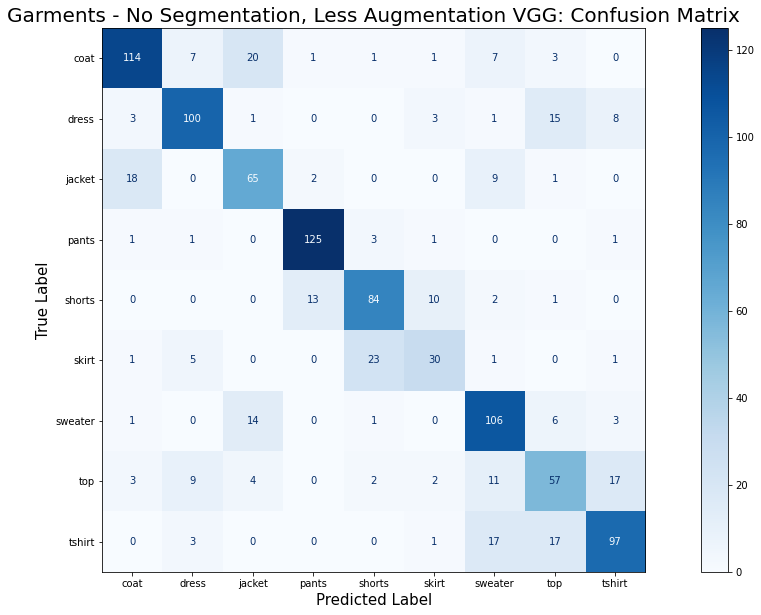

In [ ]:
model_vg_nsa = model_function(classes = 9,alr=.01)

train_data = tensor_data(la_train_gen,clothes_df,data_path,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'garment_label','validation')

checkpoint_model_vg_nsa = checkpoint('model_vg_nsa')

history_vg_nsa = model_vg_nsa.fit(
    train_data,
    batch_size = 32,
    epochs=50,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_nsa,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_vg_nsa,'Garments - No Segmentation, Less Augmentation VGG: Accuracy',
              'nsa_garment_transfer')

plot_confusion_matrix('model_vg_nsa',test_data,
                      'Garments - No Segmentation, Less Augmentation VGG: Confusion Matrix',
                      'nsa_garment_transfer')

In [ ]:
max(history_vg_nsa.history['val_accuracy'])

0.7381404042243958

In [ ]:
calculate_balanced_acc('model_vg_nsa',clothes_df,data_path,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.7178638168016936

A model with less augmentation, using no segmentation, had the best balanced accuracy score on the garment data, with a score of 71.78%.